# Lale and its Impact on the Data Science Workflow

Guillaume Baudart, Martin Hirzel, Kiran Kate, Pari Ram, and Avi Shinnar

27 March 2020

Examples, documentation, code: https://github.com/ibm/lale

<img src="https://raw.githubusercontent.com/IBM/lale/d8ecf5c46e46653eb65a9eecc14dc991372cc162/docs/img/lale_logo.jpg" alt="logo" width="140px" align="left"/>

## Value Proposition

- **target user**: data scientist familiar with Python and scikit-learn
- **scope**: data preparation and machine learning (including some DL)
- **value**: consistent API for both manual machine learning and auto-ML

<img src="https://raw.githubusercontent.com/IBM/lale/d8ecf5c46e46653eb65a9eecc14dc991372cc162/examples/img/2019-1105-three-values.png" style="width:350px" align="left">

In [1]:
!pip install lale

## Example Dataset

In [2]:
import lale.datasets
(train_X_all, train_y_all), (test_X, test_y) = lale.datasets.covtype_df(test_size=0.1)
print(f'shape train_X_all {train_X_all.shape}, test_X {test_X.shape}')

shape train_X_all (522910, 54), test_X (58102, 54)


In [3]:
import sklearn.model_selection
train_X, other_X, train_y, other_y = sklearn.model_selection.train_test_split(
    train_X_all, train_y_all, test_size=0.9)
print(f'shape train_X {train_X.shape}, other_X {other_X.shape}')

shape train_X (52291, 54), other_X (470619, 54)


In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.concat([pd.DataFrame({'y': train_y}, index=train_X.index),
           train_X], axis=1).tail(10)

,y,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
236840,1,3292.0,90.0,11.0,778.0,146.0,551.0,237.0,222.0,114.0,1148.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169510,2,2721.0,97.0,11.0,212.0,29.0,2184.0,239.0,224.0,114.0,6670.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496912,2,3135.0,159.0,10.0,175.0,3.0,309.0,231.0,242.0,142.0,5050.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139505,2,2788.0,226.0,17.0,210.0,39.0,1968.0,195.0,254.0,192.0,1026.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202427,3,2538.0,139.0,13.0,212.0,50.0,997.0,239.0,236.0,124.0,1168.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240860,1,3186.0,293.0,23.0,300.0,80.0,256.0,151.0,228.0,215.0,778.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310422,1,3165.0,15.0,9.0,127.0,13.0,4583.0,212.0,221.0,146.0,3149.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226483,1,3224.0,305.0,4.0,30.0,3.0,5756.0,209.0,237.0,167.0,780.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507429,1,3287.0,188.0,7.0,1068.0,147.0,2300.0,221.0,245.0,159.0,2184.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208784,1,3054.0,270.0,2.0,201.0,33.0,3955.0,214.0,239.0,163.0,2671.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Manual Pipeline

In [5]:
from sklearn.decomposition import PCA
from xgboost import XGBClassifier as XGBoost
lale.wrap_imported_operators()

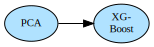

In [6]:
manual_trainable = PCA(n_components=6) >> XGBoost(n_estimators=3)
manual_trainable.visualize()

In [7]:
%%time
manual_trained = manual_trainable.fit(train_X, train_y)

CPU times: user 1.76 s, sys: 124 ms, total: 1.88 s
Wall time: 1.92 s


In [8]:
import sklearn.metrics
manual_y = manual_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, manual_y):.1%}')

accuracy 64.7%


## Hyperparameter Tuning

In [9]:
XGBoost.hyperparam_schema('n_estimators')

{'description': 'Number of trees to fit.',
 'type': 'integer',
 'default': 100,
 'minimumForOptimizer': 10,
 'maximumForOptimizer': 1500}

In [10]:
print(PCA.documentation_url())

https://lale.readthedocs.io/en/latest/modules/lale.lib.sklearn.pca.html


In [11]:
from lale.lib.lale import Hyperopt
import lale.schemas as schemas

CustomPCA = PCA.customize_schema(n_components=schemas.Int(min=2, max=54))
CustomXGBoost = XGBoost.customize_schema(n_estimators=schemas.Int(min=1, max=10))

hpo_planned = CustomPCA >> CustomXGBoost
hpo_trainable = Hyperopt(estimator=hpo_planned, max_evals=10, cv=3)

In [12]:
%%time
hpo_trained = hpo_trainable.fit(train_X, train_y)

100%|██████████| 10/10 [01:24<00:00,  7.04s/trial, best loss: -0.7894858819905374]
CPU times: user 1min 32s, sys: 580 ms, total: 1min 33s
Wall time: 1min 35s


### --- Excursions: Types as Search Spaces ---

<img src="https://raw.githubusercontent.com/IBM/lale/d8ecf5c46e46653eb65a9eecc14dc991372cc162/examples/img/2019-1208-loops.png" style="width:700px" align="left">

In [13]:
hpo_y = hpo_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, hpo_y):.1%}')

accuracy 80.6%


## Inspecting Automation Results

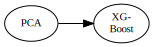

In [14]:
hpo_trained.get_pipeline().visualize()

In [15]:
hpo_trained.get_pipeline().pretty_print(ipython_display=True)

```python
from lale.lib.sklearn import PCA
from lale.lib.xgboost.xgb_classifier import XGBoost
import lale
lale.wrap_imported_operators()

pca = PCA(n_components=39, svd_solver='full')
xg_boost = XGBoost(colsample_bylevel=0.6016063807304212, colsample_bytree=0.7763972782064467, learning_rate=0.16389357351003786, max_depth=10, min_child_weight=5, n_estimators=5, reg_alpha=0.10485915855270356, reg_lambda=0.9268502695024392, subsample=0.4503841871781402)
pipeline = pca >> xg_boost
```

In [16]:
hpo_trained.summary()

,log_loss,loss,status,tid,time
name,,,,,
p0,1.240758,-0.672659,ok,0,1.422224
p1,1.114808,-0.637758,ok,1,1.565415
p2,1.082147,-0.674036,ok,2,2.915829
p3,1.044961,-0.789486,ok,3,6.865023
p4,0.654024,-0.724733,ok,4,4.249287
p5,1.234029,-0.485801,ok,5,1.990323
p6,1.332531,-0.485801,ok,6,1.189157
p7,0.838120,-0.674725,ok,7,2.493740
p8,0.916718,-0.631370,ok,8,1.917282


In [17]:
worst_name = hpo_trained.summary().loss.argmax()
print(worst_name)

p5


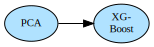

```python
pca = PCA(n_components=48, svd_solver='full', whiten=True)
xg_boost = XGBoost(booster='gblinear', colsample_bylevel=0.41777546097517426, colsample_bytree=0.6852556915729863, learning_rate=0.4299362917360751, max_depth=15, min_child_weight=18, n_estimators=7, reg_alpha=0.5266202371276923, reg_lambda=0.494226267796831, subsample=0.8015579071911012)
pipeline = pca >> xg_boost
```

In [18]:
hpo_trained.get_pipeline(worst_name).visualize()
hpo_trained.get_pipeline(worst_name).pretty_print(ipython_display=True, show_imports=False)

## Combined Algorithm Selection and Hyperparameter Tuning

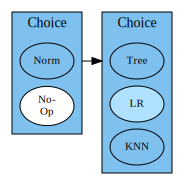

In [19]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from lale.lib.lale import NoOp
lale.wrap_imported_operators()

KNN = KNN.customize_schema(n_neighbors=schemas.Int(min=1, max=10))
transp_planned = (Norm | NoOp) >> (Tree | LR(dual=True) | KNN)
transp_planned.visualize()

In [20]:
%%time
transp_trained = transp_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=5)

100%|██████████| 5/5 [02:13<00:00, 24.85s/trial, best loss: -0.8403937240749474]
CPU times: user 2min 13s, sys: 152 ms, total: 2min 13s
Wall time: 2min 15s


### ---  Excursion: Bindings as Lifecycle ---

<img src="https://raw.githubusercontent.com/IBM/lale/d8ecf5c46e46653eb65a9eecc14dc991372cc162/examples/img/2019-1105-bindings.png" style="width:450px" align="left">

```python
knn = KNN(algorithm='ball_tree', metric='manhattan', n_neighbors=9)
pipeline = NoOp() >> knn
```

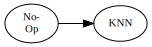

In [21]:
transp_trained.pretty_print(ipython_display=True, show_imports=False)
transp_trained.visualize()

In [22]:
%%time
transp_y = transp_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, transp_y):.1%}')

accuracy 86.5%
CPU times: user 45.3 s, sys: 20 ms, total: 45.4 s
Wall time: 46.1 s


## Non-Linear Pipeline

In [23]:
test_X.json_schema

{'description': 'Features of forest covertypes dataset (classification).',
 'documentation_url': 'https://scikit-learn.org/0.20/datasets/index.html#forest-covertypes',
 'type': 'array',
 'items': {'type': 'array',
  'minItems': 54,
  'maxItems': 54,
  'items': [{'description': 'Elevation', 'type': 'integer'},
   {'description': 'Aspect', 'type': 'integer'},
   {'description': 'Slope', 'type': 'integer'},
   {'description': 'Horizontal_Distance_To_Hydrology', 'type': 'integer'},
   {'description': 'Vertical_Distance_To_Hydrology', 'type': 'integer'},
   {'description': 'Horizontal_Distance_To_Roadways', 'type': 'integer'},
   {'description': 'Hillshade_9am', 'type': 'integer'},
   {'description': 'Hillshade_Noon', 'type': 'integer'},
   {'description': 'Hillshade_3pm', 'type': 'integer'},
   {'description': 'Horizontal_Distance_To_Fire_Points', 'type': 'integer'},
   {'description': 'Wilderness_Area1', 'enum': [0, 1]},
   {'description': 'Wilderness_Area2', 'enum': [0, 1]},
   {'descrip

In [24]:
area_columns = [f'Wilderness_Area{i}' for i in range(1, 5)]
soil_columns = [f'Soil_Type{i}' for i in range(1, 41)]
binary_columns = area_columns + soil_columns
other_columns = [c for c in train_X.columns if c not in binary_columns]
print(f'other columns: {", ".join(other_columns)}')

other columns: Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways, Hillshade_9am, Hillshade_Noon, Hillshade_3pm, Horizontal_Distance_To_Fire_Points


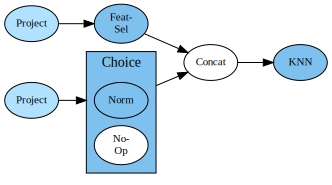

In [25]:
from lale.lib.lale import Project
from lale.lib.lale import ConcatFeatures as Concat
from sklearn.feature_selection import SelectKBest as FeatSel
lale.wrap_imported_operators()

binary_prep = Project(columns=binary_columns) >> FeatSel
other_prep = Project(columns=other_columns) >> (Norm | NoOp)
nonlin_planned = (binary_prep & other_prep) >> Concat >> KNN
nonlin_planned.visualize()

In [26]:
%%time
nonlin_trained = nonlin_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=5)

100%|██████████| 5/5 [02:45<00:00, 27.11s/trial, best loss: -0.8620988505211854]
CPU times: user 2min 44s, sys: 232 ms, total: 2min 44s
Wall time: 2min 47s


### --- Excursion: Combinators ---

| Lale feature            | Name | Description  | Scikit-learn feature                |
| ----------------------- | ---- | ------------ | ----------------------------------- |
| >> or `make_pipeline`   | pipe | feed to next | `make_pipeline`                     |
| & or `make_union`       | and  | run both     | `make_union` or `ColumnTransformer` |
| &#x7c; or `make_choice` | or   | choose one   | N/A (specific to given AutoML tool) |

### --- Excursion: Interoperability ---

<img src="https://raw.githubusercontent.com/IBM/lale/d8ecf5c46e46653eb65a9eecc14dc991372cc162/examples/img/2019-1105-interop.png" style="width:550px" align="left">

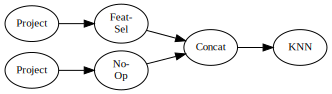

```python
project_0 = Project(columns=['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'])
feat_sel = FeatSel(k=8)
pipeline_0 = make_pipeline(project_0, feat_sel)
project_1 = Project(columns=['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'])
pipeline_1 = make_pipeline(project_1, NoOp())
union = make_union(pipeline_0, pipeline_1)
knn = KNN(algorithm='kd_tree', n_neighbors=7, weights='distance')
pipeline = make_pipeline(union, knn)
```

In [27]:
nonlin_trained.visualize()
nonlin_trained.pretty_print(ipython_display=True, show_imports=False, combinators=False)

In [28]:
%%time
nonlin_y = nonlin_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, nonlin_y):.1%}')

accuracy 88.5%
CPU times: user 3.68 s, sys: 16 ms, total: 3.7 s
Wall time: 3.74 s


In [29]:
binary_prep_trainable = Project(columns=binary_columns) >> FeatSel(k=8)
binary_prep_trained = binary_prep_trainable.fit(train_X, train_y)
binary_prep_trained.transform(test_X.head(10))

,Wilderness_Area1,Wilderness_Area4,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type10,Soil_Type38,Soil_Type39
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Summary

- code and documentation: https://github.com/ibm/lale
- more examples: https://nbviewer.jupyter.org/github/IBM/lale/tree/master/examples/
- frequently asked questions: https://github.com/IBM/lale/blob/master/docs/faq.rst
- arXiv paper: https://arxiv.org/pdf/1906.03957.pdf

<img src="https://raw.githubusercontent.com/IBM/lale/d8ecf5c46e46653eb65a9eecc14dc991372cc162/examples/img/2019-1105-summary.png" style="width:350px" align="left">